# Pylops - basic linear operators on GPU with cupy

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops* and test both their numpy and cupy backends.

In [1]:
!nvidia-smi

Mon Feb 15 09:18:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:65:00.0  On |                  N/A |
| 30%   47C    P0    51W / 125W |   2055MiB /  7979MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  1
Core(s) per socket:  8
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) W-2145 CPU @ 3.70GHz
Stepping:            4
CPU MHz:             1900.006
CPU max MHz:         4500.0000
CPU min MHz:         1200.0000
BogoMIPS:            7399.70
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            11264K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 s

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import timeit
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.optimization.solver import cgls
from pylops.optimization.leastsquares import *

plt.style.use('seaborn-dark')

In [5]:
cp.__version__

'8.4.0'

In [6]:
def timing(cmd_setup, df, method, number=10, repeat=5):
    # _matvec
    mat_np = 'Op._matvec(x)'
    mat_cp = 'cOp._matvec(xc)'

    # _matvec
    rmat_np = 'Op._rmatvec(y)'
    rmat_cp = 'cOp._rmatvec(yc)'

    # dry run
    timeit.repeat(mat_cp, setup=cmd_setup, number=1, repeat=1)
    timeit.repeat(rmat_cp, setup=cmd_setup, number=1, repeat=1)

    # timing
    tm_ = 1.e3 * np.array(timeit.repeat(mat_np, setup=cmd_setup,
                                      number=number, repeat=repeat))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_np, setup=cmd_setup,
                                       number=number, repeat=repeat))
    for i in range(repeat):
        df.loc[len(df)] = [method, True, 'np', tm_[i]]
    for i in range(repeat):
        df.loc[len(df)] = [method, False, 'np', + trm_[i]]

    tm_ = 1.e3 * np.array(timeit.repeat(mat_cp, setup=cmd_setup,
                                      number=number, repeat=repeat))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_cp, setup=cmd_setup,
                                       number=number, repeat=repeat))
    for i in range(repeat):
        df.loc[len(df)] = [method, True, 'cp', tm_[i]]
    for i in range(repeat):
        df.loc[len(df)] = [method, False, 'cp', trm_[i]]
    return df

# Elementary operators

In [7]:
df = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

## Diagonal

In [8]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
d = np.arange(n) + 1.
y = x = np.ones(n)
yc = xc = cp.ones(n)
Op = pylops.Diagonal(d)
cOp = pylops.Diagonal(cp.array(d))
"""

df = timing(cmd_setup, df, 'Diagonal')

## Matrix Multiplication

In [9]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = 1000
D = np.ones((n, n))
y = x = np.ones(n)
yc = xc = cp.ones(n)
Op = pylops.MatrixMult(D)
cOp = pylops.MatrixMult(cp.array(D))
"""

df = timing(cmd_setup, df, 'MatrixMult')

## Identity

In [10]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n//2)
xc = cp.ones(n//2)
y = np.ones(n)
yc = cp.ones(n)
Op = pylops.Identity(n, n//2)
cOp = pylops.Identity(n, n//2)
"""

df = timing(cmd_setup, df, 'Identity')

## Zero

In [11]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = int(1e6), int(1e6)
y = x = cp.arange(nx)
yc = xc = cp.ones(nx)
Op = pylops.Zero(ny, nx)
cOp = pylops.Zero(ny, nx)
"""

df = timing(cmd_setup, df, 'Zero')

## Sum

In [12]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx)
yc = cp.ones(nx)
Op = pylops.Sum(dims=(ny, nx), dir=0)
cOp = pylops.Sum(dims=(ny, nx), dir=0)
"""
df = timing(cmd_setup, df, 'Sum')

## First Derivative

In [13]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.FirstDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
cOp = pylops.FirstDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
"""
df = timing(cmd_setup, df, 'FirstDerivative')

## Second Derivative

In [14]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.SecondDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
cOp = pylops.SecondDerivative(ny*nx, (ny, nx), dir=-1, edge=True)
"""
df = timing(cmd_setup, df, 'SecondDerivative')

## Laplacian

In [15]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Laplacian')

## Gradient

In [16]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Laplacian((ny, nx), edge=True)
cOp = pylops.Laplacian((ny, nx), edge=True)
"""
df = timing(cmd_setup, df, 'Gradient')

## Causal Integration

In [17]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.CausalIntegration(ny*nx, (ny, nx), dir=1)
cOp = pylops.CausalIntegration(ny*nx, (ny, nx), dir=1)
"""
df = timing(cmd_setup, df, 'CausalIntegration')

## Flip

In [18]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Flip(ny*nx, (ny, nx), dir=1)
cOp = pylops.Flip(ny*nx, (ny, nx), dir=1)
"""
df = timing(cmd_setup, df, 'Flip')

## Pad

In [19]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
pad = (200, 200)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n + 400)
yc = cp.ones(n + 400)
Op = pylops.Pad(n, pad)
cOp = pylops.Pad(n, pad)
"""
df = timing(cmd_setup, df, 'Pad')

## Roll

In [20]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n)
yc = cp.ones(n)
Op = pylops.Roll(n, shift=20)
cOp = pylops.Roll(n, shift=20)
"""
df = timing(cmd_setup, df, 'Roll')

## Symmetrize


In [21]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n*2-1)
yc = cp.ones(n*2-1)
Op = pylops.Symmetrize(n)
cOp = pylops.Symmetrize(n)
"""
df = timing(cmd_setup, df, 'Symmetrize')

## Restriction

In [22]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
iava = np.arange(0,n,10)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n//10)
yc = cp.ones(n//10)
Op = pylops.Restriction(n, iava)
cOp = pylops.Restriction(n, iava)
"""
df = timing(cmd_setup, df, 'Restriction')

## Transpose

In [23]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.Transpose((ny, nx), axes=(1,0))
cOp = pylops.Transpose((ny, nx), axes=(1,0))
"""
df = timing(cmd_setup, df, 'Transpose')

## FFT

In [24]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n*2-1)
yc = cp.ones(n*2-1)
Op = pylops.signalprocessing.FFT(dims=[n], nfft=n)
cOp = pylops.signalprocessing.FFT(dims=[n], nfft=n)
"""
df = timing(cmd_setup, df, 'FFT')

## FFT2D

In [25]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
ny, nx = 1000, 1000
x = np.ones(nx*ny)
xc = cp.ones(nx*ny)
y = np.ones(nx*ny)
yc = cp.ones(nx*ny)
Op = pylops.signalprocessing.FFT2D(dims=[ny, nx])
cOp = pylops.signalprocessing.FFT2D(dims=[ny, nx])
"""
df = timing(cmd_setup, df, 'FFT2D')

## FFTND

In [26]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nz, ny, nx = 50, 100, 100
x = np.ones(nz*nx*ny)
xc = cp.ones(nz*nx*ny)
y = np.ones(nz*nx*ny)
yc = cp.ones(nz*nx*ny)
Op = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
cOp = pylops.signalprocessing.FFTND(dims=[nz, ny, nx])
"""
df = timing(cmd_setup, df, 'FFTND')

## Convolve 1D

In [27]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n)
yc = cp.ones(n)
h = np.ones(25)
hc = cp.ones(25)
Op = pylops.signalprocessing.Convolve1D(n, h)
cOp = pylops.signalprocessing.Convolve1D(n, hc)
"""
df = timing(cmd_setup, df, 'Convolve1D')

## Convolve2D

In [28]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nx = 1000, 1000
h = np.ones((5,5))
hc = cp.ones((5,5))
x = np.ones(nt*nx)
xc = cp.ones(nt*nx)
y = np.ones(nt*nx)
yc = cp.ones(nt*nx)
Op = pylops.signalprocessing.Convolve2D(nt*nx, h, (nt, nx))
cOp = pylops.signalprocessing.Convolve2D(nt*nx, h, (nt, nx))

"""
df = timing(cmd_setup, df, 'Convolve2D')

## ConvolveND

In [29]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, ny, nx = 100, 100, 100
h = np.ones((10, 10, 10))
hc = cp.ones((10,10))
x = np.ones(nt*ny*nx)
xc = cp.ones(nt*ny*nx)
y = np.ones(nt*ny*nx)
yc = cp.ones(nt*ny*nx)
Op = pylops.signalprocessing.ConvolveND(nt*ny*nx, h, (nt, ny, nx))
cOp = pylops.signalprocessing.ConvolveND(nt*ny*nx, h, (nt, ny, nx))

"""
df = timing(cmd_setup, df, 'ConvolveND')

## ChirpRadon2D

In [30]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh = 1000, 1000
t = np.arange(nt)
h = np.arange(nh)
x = np.ones(nt*nh)
xc = cp.ones(nt*nh)
y = np.ones(nt*nh)
yc = cp.ones(nt*nh)
Op = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)
cOp = pylops.signalprocessing.ChirpRadon2D(t, h, 0.001)

"""
df = timing(cmd_setup, df, 'ChirpRadon2D')

## ChirpRadon3D

In [31]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh1, nh2 = 100, 100, 100
t = np.arange(nt)
h1 = np.arange(nh1)
h2 = np.arange(nh2)
x = np.ones(nt*nh1*nh2)
xc = cp.ones(nt*nh1*nh2)
y = np.ones(nt*nh1*nh2)
yc = cp.ones(nt*nh1*nh2)
Op = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001), engine='fftw')
cOp = pylops.signalprocessing.ChirpRadon3D(t, h1, h2, (0.001, 0.001))

"""
df = timing(cmd_setup, df, 'ChirpRadon3D')

## Interp

In [32]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
n = int(1e6)
iava = np.arange(0,n,10) + 0.5
x = np.ones(n)
xc = cp.ones(n)
y = np.ones(n//10)
yc = cp.ones(n//10)
Op = pylops.signalprocessing.Interp(n, iava, kind='nearest')[0]
cOp = pylops.signalprocessing.Interp(n, iava, kind='nearest')[0]
"""
df = timing(cmd_setup, df, 'Interp')

## Bilinear

In [33]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nx = 1000, 1000
#iava = np.vstack((np.arange(0,nt,2),
#                  np.arange(0,nx,2)))
iava = np.vstack((np.hstack([i * np.ones(100) for i in range(nt-1)]),
                  np.hstack([np.random.permutation(np.arange(100)) for i in range(nt-1)])))
iavac = cp.asarray(iava)
x = np.ones(nt*nx)
xc = cp.ones(nt*nx)
y = np.ones(iava.shape[1])
yc = cp.ones(iava.shape[1])
Op = pylops.signalprocessing.Bilinear(iava, (nt, nx))
cOp = pylops.signalprocessing.Bilinear(iavac, (nt, nx))
"""
df = timing(cmd_setup, df, 'Bilinear')

/home/ravasim/miniconda3/envs/pylops_cupy_cusignal/lib/python3.8/site-packages/cupyx/_scatter.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[cupy.array(seq)]`, which will result either in an error or a different result.
  a.scatter_add(slices, value)
/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/home/ravasim/Documents/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

## Fredholm1

In [34]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
nt, nh1, nh2, nz = 100, 50, 50, 20
h = np.ones((nt, nh1, nh2))
hc = cp.ones((nt, nh1, nh2))
x = np.ones(nt*nh2*nz)
xc = cp.ones(nt*nh2*nz)
y = np.ones(nt*nh1*nz)
yc = cp.ones(nt*nh1*nz)
Op = pylops.signalprocessing.Fredholm1(h, nz)
cOp = pylops.signalprocessing.Fredholm1(hc, nz)
"""
df = timing(cmd_setup, df, 'Fredholm1')

In [35]:
#df=df[df['Method']!='Bilinear']

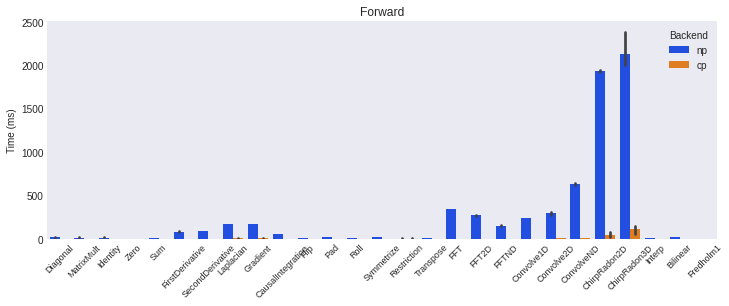

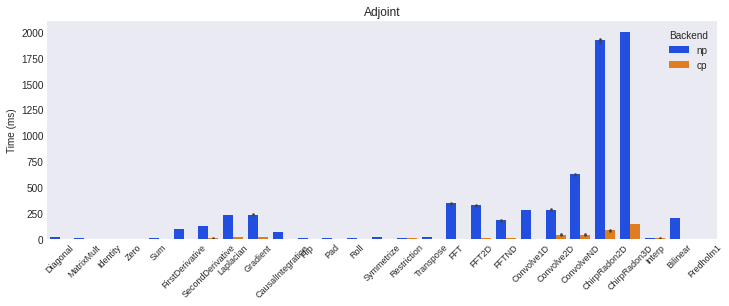

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==True], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==False], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9);

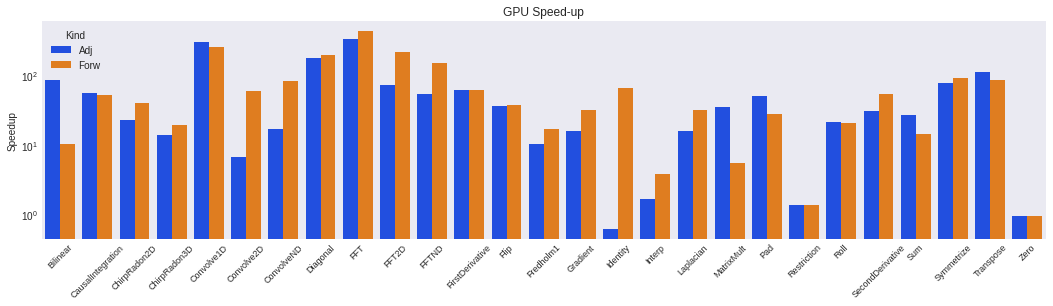

In [37]:
df_np = df[df['Backend'] == 'np']
df_cp = df[df['Backend'] == 'cp']

df_speedup = df_np.groupby(['Method', 'Forw']).mean() / df_cp.groupby(['Method', 'Forw']).mean()
df_speedup = pd.DataFrame(df_speedup.to_records())
df_speedup['Forw'] = df_speedup['Forw'].map({True: 'Forw', False: 'Adj'})
df_speedup = df_speedup.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

fig, ax = plt.subplots(figsize=(18, 4))
g = sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_speedup, palette="bright")
g.set_yscale("log")
ax.set_xlabel('')
ax.set_title('GPU Speed-up')
ax.set_xticklabels(df_speedup['Method'].unique(),rotation=45, fontsize=9);

plt.savefig('Speedup.eps', dpi=300, bbox_inches='tight')

In [38]:
print(df_speedup)

               Method  Kind     Speedup
0            Bilinear   Adj   87.320490
1            Bilinear  Forw   10.265064
2   CausalIntegration   Adj   56.626825
3   CausalIntegration  Forw   52.327019
4        ChirpRadon2D   Adj   23.105806
5        ChirpRadon2D  Forw   40.702982
6        ChirpRadon3D   Adj   14.075977
7        ChirpRadon3D  Forw   19.558677
8          Convolve1D   Adj  300.081329
9          Convolve1D  Forw  255.197904
10         Convolve2D   Adj    6.790194
11         Convolve2D  Forw   59.052445
12         ConvolveND   Adj   16.766678
13         ConvolveND  Forw   82.706551
14           Diagonal   Adj  178.529788
15           Diagonal  Forw  196.659363
16                FFT   Adj  333.504175
17                FFT  Forw  434.478695
18              FFT2D   Adj   73.129410
19              FFT2D  Forw  215.286123
20              FFTND   Adj   54.184452
21              FFTND  Forw  151.840721
22    FirstDerivative   Adj   61.289490
23    FirstDerivative  Forw   62.893917


In [39]:
print('Average speed-up operators', np.mean(df_speedup['Speedup']))

Average speed-up operators 68.8694332140358


# Composite operators

## PoststackLinearModelling

In [59]:
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

number, repeat = 10, 5

In [60]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0])
wavc = cp.asarray(wav)
nt, nx = 1000, 1000
x = np.ones(nt*nx)
xc = cp.ones(nt*nx)
y = np.ones(nt*nx)
yc = cp.ones(nt*nx)
Op = pylops.avo.poststack.PoststackLinearModelling(wav, nt, nx)
cOp = pylops.avo.poststack.PoststackLinearModelling(wavc, nt, nx)
"""
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])
df_comp = timing(cmd_setup, df_comp, 'PoststackLinearModelling_2D', number=number, repeat=repeat)

In [61]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0])
wavc = cp.asarray(wav)
nt, nx, ny = 1000, 10, 100
x = np.ones(nt*nx*ny)
xc = cp.ones(nt*nx*ny)
y = np.ones(nt*nx*ny)
yc = cp.ones(nt*nx*ny)
Op = pylops.avo.poststack.PoststackLinearModelling(wav, nt, (nx, ny))
cOp = pylops.avo.poststack.PoststackLinearModelling(wavc, nt, (nx, ny))
"""
df_comp = timing(cmd_setup, df_comp, 'PoststackLinearModelling_3D', number=number, repeat=repeat)

## PrestackLinearModelling

In [62]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0])
wavc = cp.asarray(wav)
theta = np.arange(0, 30, 5.)
thetac = cp.arange(0, 30, 5.)
ntheta = len(theta)
nt, nx = 1000, 1000
x = np.ones(nt*nx*3)
xc = cp.ones(nt*nx*3)
y = np.ones(nt*nx*ntheta)
yc = cp.ones(nt*nx*ntheta)
Op = pylops.avo.prestack.PrestackLinearModelling(wav, theta, 0.5, nt, nx)
cOp = pylops.avo.prestack.PrestackLinearModelling(wavc, thetac, 0.5, nt, nx)
"""
df_comp = timing(cmd_setup, df_comp, 'PrestackLinearModelling_2D', number=number, repeat=repeat)

In [63]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
wav = (pylops.utils.wavelets.ricker(np.arange(51)*0.004, 20)[0])
wavc = cp.asarray(wav)
theta = np.arange(0, 30, 5.)
thetac = cp.arange(0, 30, 5.)
ntheta = len(theta)
nt, nx, ny = 1000, 10, 100
x = np.ones(nt*nx*ny*3)
xc = cp.ones(nt*nx*ny*3)
y = np.ones(nt*nx*ny*ntheta)
yc = cp.ones(nt*nx*ny*ntheta)
Op = pylops.avo.prestack.PrestackLinearModelling(wav, theta, 0.5, nt, (nx, ny))
cOp = pylops.avo.prestack.PrestackLinearModelling(wavc, thetac, 0.5, nt, (nx, ny))
"""
df_comp = timing(cmd_setup, df_comp, 'PrestackLinearModelling_3D', number=number, repeat=repeat)

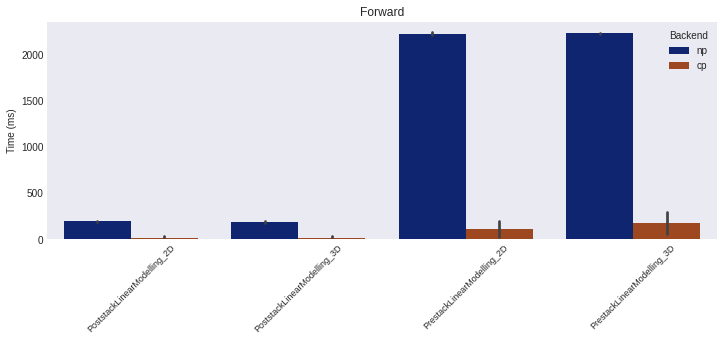

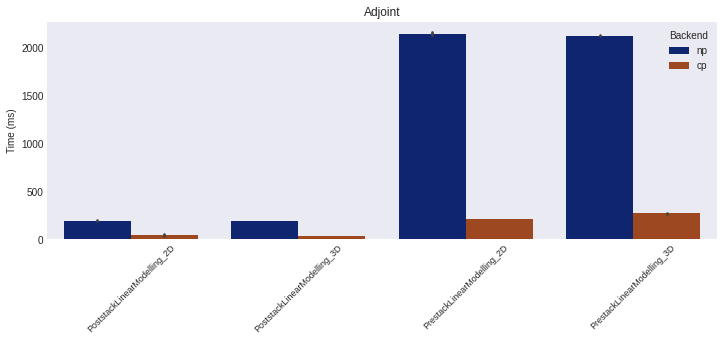

In [64]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==True], palette="dark")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==False], palette="dark")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9);

In [65]:
df_comp_np = df_comp[df_comp['Backend'] == 'np']
df_comp_cp = df_comp[df_comp['Backend'] == 'cp']

df_comp_speedup = df_comp_np.groupby(['Method', 'Forw']).mean() / df_comp_cp.groupby(['Method', 'Forw']).mean()
df_comp_speedup = pd.DataFrame(df_comp_speedup.to_records())
df_comp_speedup['Forw'] = df_comp_speedup['Forw'].map({True: 'Forw', False: 'Adj'})
df_comp_speedup = df_comp_speedup.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

In [66]:
print(df_comp_speedup)

                        Method  Kind    Speedup
0  PoststackLinearModelling_2D   Adj   4.213610
1  PoststackLinearModelling_2D  Forw  12.606533
2  PoststackLinearModelling_3D   Adj   5.551755
3  PoststackLinearModelling_3D  Forw   9.629610
4   PrestackLinearModelling_2D   Adj  10.137013
5   PrestackLinearModelling_2D  Forw  19.663094
6   PrestackLinearModelling_3D   Adj   7.766390
7   PrestackLinearModelling_3D  Forw  12.713874


In [67]:
print('Average speed-up Convmodelling', np.mean(df_comp_speedup['Speedup']))

Average speed-up Convmodelling 10.28523492566096


## PhaseShift

In [68]:
df_comp = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

number, repeat = 10, 5

In [69]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
vel = 1500.
zprop = 100
pad = 11
nt, dt = 1000, 0.004
nx, dx = 1000, 10
freq = np.fft.rfftfreq(nt, dt)
kx = np.fft.fftshift(np.fft.fftfreq(nx + 2*pad, dx))
x = np.ones(nt*(nx+2*pad))
xc = cp.ones(nt*(nx+2*pad))
y = np.ones(nt*(nx+2*pad))
yc = cp.ones(nt*(nx+2*pad))
Op = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, freq, kx)
cOp = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, cp.asarray(freq), cp.asarray(kx))
"""
df_comp = timing(cmd_setup, df_comp, 'PhaseShift_2D', number=number, repeat=repeat)

In [70]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import pylops
vel = 1500.
zprop = 100
pad = 11
nt, dt = 100, 0.004
nx, dx = 100, 10
ny, dy = 100, 10
freq = np.fft.rfftfreq(nt, dt)
kx = np.fft.fftshift(np.fft.fftfreq(nx + 2*pad, dx))
ky = np.fft.fftshift(np.fft.fftfreq(ny + 2*pad, dy))
x = np.ones(nt*(nx+2*pad)*(ny+2*pad))
xc = cp.ones(nt*(nx+2*pad)*(ny+2*pad))
y = np.ones(nt*(nx+2*pad)*(ny+2*pad))
yc = cp.ones(nt*(nx+2*pad)*(ny+2*pad))
Op = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, freq, kx, ky)
cOp = pylops.waveeqprocessing.PhaseShift(vel, zprop, nt, cp.asarray(freq), cp.asarray(kx), cp.asarray(ky))
"""
df_comp = timing(cmd_setup, df_comp, 'PhaseShift_3D', number=number, repeat=repeat)

In [71]:
#df_comp['Time'] /= 1000 # ms -> s

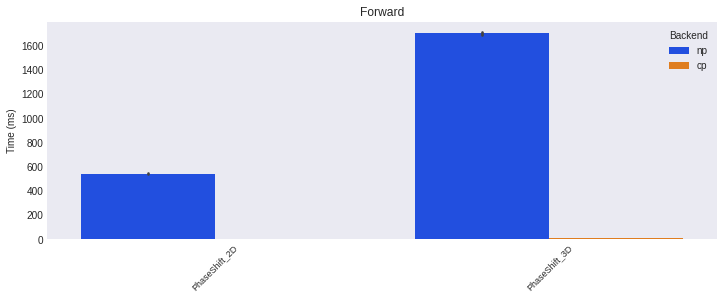

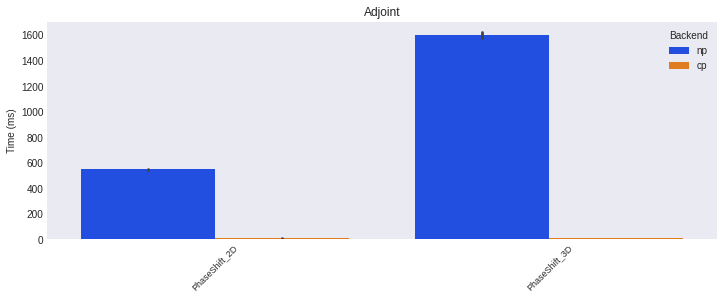

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==True], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_comp[df_comp['Forw']==False], palette="bright")
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df_comp['Method'].unique(),rotation=45, fontsize=9);

In [73]:
df_comp_np = df_comp[df_comp['Backend'] == 'np']
df_comp_cp = df_comp[df_comp['Backend'] == 'cp']

df_comp_speedup1 = df_comp_np.groupby(['Method', 'Forw']).mean() / df_comp_cp.groupby(['Method', 'Forw']).mean()
df_comp_speedup1 = pd.DataFrame(df_comp_speedup1.to_records())
df_comp_speedup1['Forw'] = df_comp_speedup1['Forw'].map({True: 'Forw', False: 'Adj'})
df_comp_speedup1 = df_comp_speedup1.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

In [74]:
print(df_comp_speedup1)

          Method  Kind     Speedup
0  PhaseShift_2D   Adj   77.415956
1  PhaseShift_2D  Forw  103.284773
2  PhaseShift_3D   Adj  169.239121
3  PhaseShift_3D  Forw  203.486204


In [75]:
print('Average speed-up Phase shift', np.mean(df_comp_speedup1['Speedup']))

Average speed-up Phase shift 138.35651343699814


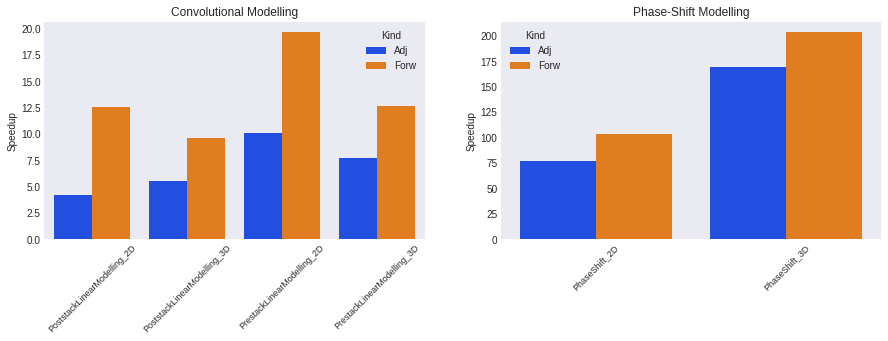

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_comp_speedup, palette="bright", ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_title('Convolutional Modelling')
axs[0].set_xticklabels(df_comp_speedup['Method'].unique(),rotation=45, fontsize=9);
sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_comp_speedup1, palette="bright", ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_title('Phase-Shift Modelling')
axs[1].set_xticklabels(df_comp_speedup1['Method'].unique(),rotation=45, fontsize=9);

plt.savefig('Speedup_composite.eps', dpi=300, bbox_inches='tight')